In [1]:
import sys
import string
import re
import datetime
from string import digits

import simplejson

import langid
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer

from collections import defaultdict
from configparser import ConfigParser
from gensim import corpora, models, similarities, matutils

import pyLDAvis.gensim  

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import statsmodels.formula.api as smf
from scipy.stats import t
from matplotlib.pylab import plt

%pylab inline



/Users/lanimc/anaconda/lib/python2.7/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


Populating the interactive namespace from numpy and matplotlib


In [2]:
tmayor = pd.read_excel('NYCMayorsOffice-tweets-12-12-19-24-lanimcl.xlsx')
tparks = pd.read_excel('NYCParks-tweets-12-12-19-29-lanimcl.xlsx')
toem = pd.read_excel('nycoem-tweets-12-12-19-28-lanimcl.xlsx')
tnycha = pd.read_excel('NYCHA-tweets-12-12-19-27-lanimcl.xlsx')
tnycgov = pd.read_excel('nycgov-tweets-12-12-19-25-lanimcl.xlsx')
tnyc311 = pd.read_excel('nyc311-tweets-12-12-19-17-lanimcl.xlsx')
tfdny = pd.read_excel('FDNY-tweets-12-12-19-01-lanimcl.xlsx')
tnypd = pd.read_excel('NYPDnews-tweets-12-12-19-00-lanimcl.xlsx')

In [3]:
tmayor['Agency'] = 'NYCMayorsOffice'
tparks['Agency'] = 'NYCParks'
toem['Agency'] = 'NYCOEM'
tnycha['Agency'] = 'NYCHA'
tnycgov['Agency'] = 'NYCGOV'
tnyc311['Agency'] = 'NYC311'
tfdny['Agency'] = 'FDNY'
tnypd['Agency'] = 'NYPDnews'

frames = [tmayor, tparks, toem, tnycha, tnycgov, tnyc311, tfdny, tnypd]

tweets = pd.concat(frames)

np.random.seed(123)

traintwts, testtwts = train_test_split(tweets, test_size = 0.85)

In [4]:
traintwts.head(3)

,link,created_at,fav,rt,text,Agency
680,0,2016-10-15 14:35:22,16,13,Today is the last day of #FirePreventionWeek! ...,FDNY
2580,0,2015-07-17 18:10:08,0,35,RT @nycgo: City of Water Day is tomorrow. Cele...,NYCParks
2062,0,2015-04-13 13:22:52,13,23,Happy National Volunteer Week! Find out how yo...,NYCOEM


In [5]:
traintwts.describe()

,link,fav,rt
count,3839.0,3839.000000,3839.000000
mean,0.0,18.653816,27.475645
std,0.0,67.437619,131.224523
min,0.0,0.000000,0.000000
25%,0.0,0.000000,2.000000
50%,0.0,2.000000,7.000000
75%,0.0,14.000000,18.000000
max,0.0,1825.000000,4410.000000


In [6]:
#Prep text column for anlaysis 
tweetsclean=traintwts.dropna(axis=0,how='any') #drop missing rows
tweetsclean.text = tweetsclean['text'].str.lower() #all lower case
tweetsclean.head()

,link,created_at,fav,rt,text,Agency
680,0,2016-10-15 14:35:22,16,13,today is the last day of #firepreventionweek! ...,FDNY
2580,0,2015-07-17 18:10:08,0,35,rt @nycgo: city of water day is tomorrow. cele...,NYCParks
2062,0,2015-04-13 13:22:52,13,23,happy national volunteer week! find out how yo...,NYCOEM
1279,0,2016-05-20 19:51:53,0,9,"rt @nyslant: if mayoral control isn't renewed,...",NYCMayorsOffice
1146,0,2016-08-09 13:02:53,0,1,writing a resume on a phone is hard. the digit...,NYCHA


In [7]:
tweetlist = pd.Series.tolist(tweetsclean['text']) #tweetlist is a python list where each tweet is a list item

In [8]:
#remove handles and urls
tweetlist = [re.sub(r"(?:\@|https?\://|http?\://)\S+", "", doc)
                for doc in tweetlist ]

In [9]:
#add single ch and two ch words to stop list
unigrams = [ w for doc in tweetlist for w in doc if len(w)==1]
bigrams  = [ w for doc in tweetlist for w in doc if len(w)==2]

stoplist  = set(nltk.corpus.stopwords.words("english")
                + unigrams + bigrams)

In [10]:
#remove stoplist from tweetlist; tokenization

wordlist = [[word for word in doc.lower().split() if word not in stoplist]
          for doc in tweetlist] #wordlist is a list(tweets) of lists(words)

In [11]:
wordlist[0]

[u'today',
 u'last',
 u'day',
 u'#firepreventionweek!',
 u"don't",
 u'forget',
 u'read',
 u'#fdnysmart',
 u'tips',
 u'keep',
 u'&amp;',
 u'family',
 u'sa\u2026']

In [12]:
print len (tweetlist)
print len (wordlist)

3839
3839


In [13]:
# remove words that appear only once

frequency = defaultdict(int)
for twt in wordlist:
    for word in twt:
        frequency[word] += 1

wordlist = [[word for word in twt if frequency[word] > 1]
          for twt in wordlist]

In [14]:
#Use Latent Dirichlet Allocation (LDA) through gensim library (https://radimrehurek.com/gensim/wiki.html#latent-dirichlet-allocation)
#to extract topics
#method: https://github.com/alexperrier/datatalks/blob/master/twitter/twitter_lsa.py and examples in gensim documentation

dictionary = corpora.Dictionary(wordlist)
corpus = [dictionary.doc2bow(doc) for doc in wordlist]#vectorized documents using bagging technique
corpora.MmCorpus.serialize('tweetcorpus.mm', corpus)#save as matrix market document

In [15]:
len(wordlist)

3839

In [16]:
#dictionary = corpora.Dictionary(wordlist)
#dictionary.compactify()
# and save the dictionary for future use
#dictionary.save('tweetdictionary.dict')
print dictionary

Dictionary(4364 unique tokens: [u'limited', u'crotona', u'searchable', u'nws', u'update.']...)


In [17]:
corpus = corpora.MmCorpus('tweetcorpus.mm') #read the mm document

In [18]:
lda_params      = {'num_topics': 20, 'passes': 100, 'alpha': 0.001, 'eval_every': 1, 'update_every':0,'random_state':123}

In [19]:
ldav = models.LdaModel(corpus, id2word=dictionary,
                        num_topics=lda_params['num_topics'],
                        passes=lda_params['passes'],
                        eval_every=lda_params['eval_every'],
                        update_every=lda_params['update_every'],
                        alpha = lda_params['alpha'],
                        random_state = lda_params['random_state'])

In [20]:
modeltopics = ldav.show_topics()
modeltopics = pd.DataFrame(modeltopics, columns=['topicnum','wordprob'])
modeltopics

,topicnum,wordprob
0,0,"0.028*""learn"" + 0.023*""rt"" + 0.019*""looking"" +..."
1,3,"0.031*""#nextgennycha"" + 0.014*""w/"" + 0.014*""rt..."
2,16,"0.035*""&amp;"" + 0.030*""park"" + 0.021*""free"" + ..."
3,7,"0.034*""get"" + 0.027*""help"" + 0.023*""ready"" + 0..."
4,6,"0.033*""&amp;"" + 0.024*""rt"" + 0.017*""info"" + 0...."
5,2,"0.042*""rt"" + 0.033*""mayor"" + 0.015*""live"" + 0...."
6,17,"0.066*""rt"" + 0.052*""de"" + 0.035*""en"" + 0.035*""..."
7,8,"0.025*""rt"" + 0.024*""&amp;"" + 0.014*""keep"" + 0...."
8,1,"0.023*""&amp;"" + 0.021*""call"" + 0.020*""heat"" + ..."
9,4,"0.026*""also"" + 0.024*""&amp;"" + 0.024*""online"" ..."


In [21]:
# # Visualize first LDA model with 20 topics
lda1 =  pyLDAvis.gensim.prepare(ldav, corpus, dictionary)
pyLDAvis.display(lda1)

In [22]:
filename = 'figure3.html'
pyLDAvis.save_html(lda1, filename)

In [23]:
lda_params      = {'num_topics': 7, 'passes': 50, 'alpha': 0.001, 'eval_every': 1, 'update_every':0,'random_state':123}

In [24]:
ldav = models.LdaModel(corpus, id2word=dictionary,
                        num_topics=lda_params['num_topics'],
                        passes=lda_params['passes'],
                        eval_every=lda_params['eval_every'],
                        update_every=lda_params['update_every'],
                        alpha = lda_params['alpha'],
                        random_state = lda_params['random_state'])

In [25]:
modeltopics = ldav.show_topics()
modeltopics = pd.DataFrame(modeltopics, columns=['topicnum','wordprob'])
modeltopics

,topicnum,wordprob
0,0,"0.026*""&amp;"" + 0.019*""rt"" + 0.016*""learn"" + 0..."
1,1,"0.033*""&amp;"" + 0.031*""report"" + 0.026*""please..."
2,2,"0.046*""rt"" + 0.016*""&amp;"" + 0.011*""mayor"" + 0..."
3,3,"0.020*""&amp;"" + 0.016*""rt"" + 0.011*""#fdny"" + 0..."
4,4,"0.032*""rt"" + 0.024*""&amp;"" + 0.009*""free"" + 0...."
5,5,"0.031*""rt"" + 0.012*""get"" + 0.010*""&amp;"" + 0.0..."
6,6,"0.036*""rt"" + 0.027*""&amp;"" + 0.024*""de"" + 0.01..."


In [54]:
topics = ldav.print_topics(num_topics=-1, num_words=10)

In [61]:
modeltopics.to_csv(path_or_buf='modeltopics', sep=',', na_rep='', float_format=None, columns=None, header=True, index=True, index_label=None, mode='w', encoding=None, compression=None, quoting=None, quotechar='"', line_terminator='\n', chunksize=None )

In [26]:
# Visualize second LDA model with  7 topics
lda2 =  pyLDAvis.gensim.prepare(ldav, corpus, dictionary)
pyLDAvis.display(lda2)

In [27]:
filename = 'figure4.html'
pyLDAvis.save_html(lda2, filename)

Pick the model with the higher likelihood score: 

In [28]:
#iterate LDA model 2 over test set

#tweetsclean=testtwts.dropna(axis=0,how='any') #drop missing rows
#tweetsclean.text = tweetsclean['text'].str.lower() #all lower case

#tweetlist = pd.Series.tolist(tweetsclean['text'])
#tweetlist = [re.sub(r"(?:\@|https?\://|http?\://)\S+", "", doc)
#                for doc in tweetlist ]

#unigrams = [ w for doc in tweetlist for w in doc if len(w)==1]
#bigrams  = [ w for doc in tweetlist for w in doc if len(w)==2]

#stoplist  = set(nltk.corpus.stopwords.words("english")
#                + unigrams + bigrams)

#wordlist = [[word for word in doc.lower().split() if word not in stoplist]
#          for doc in tweetlist] #wordlist is a list(tweets) of lists(words)

#frequency = defaultdict(int)
#for twt in wordlist:
#    for word in twt:
#        frequency[word] += 1

#doc_bow = [[word for word in twt if frequency[word] > 1]
#          for twt in wordlist]


#doc_lda = ldav[doc_bow]

In [29]:
#cross validate for highest log likelihood against test set


In [30]:
# get the probability of each topic per tweet as features for predicting retweets
print(corpus)

TopicDistPTweet =[]

for document in corpus:
    for i in xrange(0,7):
        TopicDist = ldav.get_document_topics(corpus[i])
        TopicDistPTweet.append(TopicDist)
 


MmCorpus(3839 documents, 4364 features, 31965 non-zero entries)


In [31]:
TopicDistPTweet

[[(0, 0.5309874954824404), (2, 0.35027093343189958), (6, 0.11840843208341147)],
 [(5, 0.68577392018962424), (6, 0.31367095601777001)],
 [(5, 0.99925065567628324)],
 [(5, 0.99850262041427496)],
 [(1, 0.7119804514688689), (4, 0.28756529214882892)],
 [(4, 0.41853136789752632), (5, 0.58084417849937664)],
 [(2, 0.99900116530714145)],
 [(0, 0.53105674508663503),
  (2, 0.35020029321254936),
  (6, 0.11840982269856713)],
 [(5, 0.68573591140589285), (6, 0.3137089648015014)],
 [(5, 0.99925065567628324)],
 [(5, 0.99850262041427496)],
 [(1, 0.7119682479370022), (4, 0.28757749568069557)],
 [(4, 0.4185943566532217), (5, 0.58078118974368109)],
 [(2, 0.99900116530714145)],
 [(0, 0.53101458819985092), (2, 0.35024329562170153), (6, 0.118408977176199)],
 [(5, 0.68574092491468519), (6, 0.313703951292709)],
 [(5, 0.99925065567628324)],
 [(5, 0.99850262041427496)],
 [(1, 0.71199539356681829), (4, 0.28755035005087948)],
 [(4, 0.41857248970795397), (5, 0.58080305668894883)],
 [(2, 0.99900116530714145)],
 [(0, 

In [70]:
TopicNPMatrix = matutils.corpus2dense(corpus, num_terms=4364, num_docs=3839)

In [83]:
print TopicNPMatrix.size
print TopicNPMatrix.shape

16753396
(4364, 3839)


In [85]:
TopicTrans = TopicNPMatrix.T

In [86]:
print TopicTrans.size
print TopicTrans.shape

16753396
(3839, 4364)


In [96]:
Topics = pd.DataFrame(TopicTrans)

In [97]:
Topics.shape

(3839, 4364)

In [98]:
Topics['tweets'] = Topics.index

In [99]:
retweets = traintwts.reset_index()

In [100]:
retweets.head()

,index,link,created_at,fav,rt,text,Agency
0,680,0,2016-10-15 14:35:22,16,13,Today is the last day of #FirePreventionWeek! ...,FDNY
1,2580,0,2015-07-17 18:10:08,0,35,RT @nycgo: City of Water Day is tomorrow. Cele...,NYCParks
2,2062,0,2015-04-13 13:22:52,13,23,Happy National Volunteer Week! Find out how yo...,NYCOEM
3,1279,0,2016-05-20 19:51:53,0,9,"RT @NYSlant: If mayoral control isn't renewed,...",NYCMayorsOffice
4,1146,0,2016-08-09 13:02:53,0,1,Writing a resume on a phone is hard. The Digit...,NYCHA


In [101]:
olsdata = pd.concat([Topics, retweets], axis=0)

In [102]:
olsdata.head()

,0,1,2,3,4,5,6,7,8,9,...,4362,4363,Agency,created_at,fav,index,link,rt,text,tweets
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,3.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,4.0


In [109]:
olsdata = olsdata.drop('Agency', 1)

In [110]:
olsdata = olsdata.drop('created_at', 1)

In [111]:
olsdata = olsdata.drop('link', 1)

In [112]:
olsdata = olsdata.drop('text', 1)

In [114]:
olsdata = olsdata.drop('index', 1)

In [115]:
olsdata.head()

,0,1,2,3,4,5,6,7,8,9,...,4357,4358,4359,4360,4361,4362,4363,fav,rt,tweets
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,3.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,4.0


In [116]:
#regress topics to retweets
regress = lambda x:smf.ols(formula = 'Retweets ~ %s'%x, data = olsdata).fit()

# For displaying R^2 and linear model summary
def modelEval(lm, key = 'rt'):
    lmy = lm.predict(olsdata)
    print(lm.summary())
    plt.plot(lmy, lmy, 'b-')
    plt.plot(lmy, data[retweet],'or')

lm = regress(str('Topic + Topic + '+ '+'.join(olsdata.columns[:4363])))
modelEval(lm, key = 'rt')

TypeError: sequence item 0: expected string, int found

/Users/lanimc/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/lanimc/anaconda/lib/python2.7/site-packages/sklearn/decomposition/pca.py:387: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


ValueError: x and y must have same first dimension

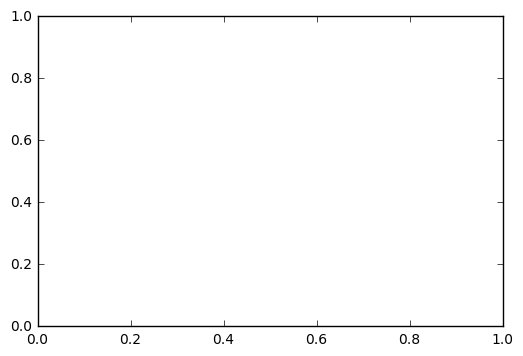

In [118]:
#check if we need run deminsionality reduction
#a.
n=64 # how many eigenvectors we choose
from sklearn.decomposition import PCA
pca = PCA(n)
Xproj = pca.fit_transform(olsdata.columns[:4363])
eigenvalues = pca.explained_variance_
plt.plot(np.arange(n), eigenvalues, 'o');

In [ ]:
#check if we need run deminsionality reduction
print "Total varaince is: {}".format(np.var(X,0).sum())
pca = PCA(0.9)
Xproj = pca.fit_transform(X)
eigenvalues = pca.explained_variance_
print("we need {} eigenvectors".format(len(Xproj.T)))

In [ ]:
#run the regression
### Question A:
import statsmodels.api as sm
y=np.asarray(data.Y)
X=np.asarray(data.iloc[:,1:])
res=sm.OLS(y,data.iloc[:,1:]).fit()
print res.summary()

#check for overfitting
from sklearn.linear_model import LinearRegression
R_IS=[]
R_OS=[]
n=1000
from sklearn.cross_validation import train_test_split
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    res=LinearRegression(fit_intercept=False)
    res.fit(X_train,y_train)
    R_IS.append(1-((np.asarray(res.predict(X_train))-y_train)**2).sum()/((y_train-np.mean(y_train))**2).sum())                                                                     
    R_OS.append(1-((np.asarray(res.predict(X_test))-y_test)**2).sum()/((y_test-np.mean(y_test))**2).sum())
print("IS R-squared for {} times is {}".format(n,np.mean(R_IS)))
print("OS R-squared for {} times is {}".format(n,np.mean(R_OS)))

#use feature selection with features of (p value<0.05)
# Question C.
y=np.asarray(data.Y)
X=np.asarray(data.iloc[:,1:])
res=sm.OLS(y,X).fit()
# Find the index for variables where pvalues< 0.05
print "pvalues<0.05:", np.where(res.pvalues<0.05)
res=sm.OLS(y,X[:,[7,12,13]]).fit()
print res.summary()